In [ ]:
# computes the metrics between GT shells and predicted shells
%load_ext line_profiler
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
from utils.utils import load_predictions, get_data, load_data, load_test_predictions, get_metrics, get_bbox_slices, get_bbox_margin, get_shells, compute_auc, get_path

In [36]:
root_path = get_path()
fig_path = os.path.join(root_path, "figures")

data_path = os.path.join(root_path, "RBC_labelled")

datasets = ["valid1", "valid2", "valid3"]

In [3]:
# load gt data
data_dict = {}
for dataset in datasets:
    imgs, gt, file_names = load_data(data_path, dataset)
    data_dict[dataset] = {"imgs": imgs,
                          "gt": gt,
                          "file_names": file_names}

In [4]:
# load prediction data
seed = 0
n_folds = 10
eval_str = "data_valid1_valid2_valid3_by_stack_mode_3D_iso_min_train_masks_0_seed_0_epoch_499_aniso_3.2"
for dataset in datasets:
    test_pred, test_idx = load_test_predictions(data_path,
                                     dataset,
                                     data_dict[dataset]["file_names"],
                                     eval_str,
                                     seed=seed,
                                     n_folds=n_folds)
    reverse_idx = np.argsort(test_idx)
    test_pred = test_pred[reverse_idx]
    data_dict[dataset]["pred"] = test_pred

In [5]:
# test shell functionality
img_id = 3
pred_shell = get_shells(data_dict["valid1"]["pred"][img_id], dilation_radius=0, erosion_radius=2)
gt_shell = get_shells(data_dict["valid1"]["gt"][img_id],  dilation_radius=0, erosion_radius=2)

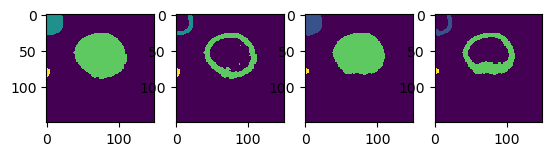

In [6]:
z=15
fig, ax = plt.subplots(1,4)
ax[0].imshow(data_dict["valid1"]["gt"][img_id][z], interpolation="none")
ax[1].imshow(gt_shell[z], interpolation="none")
ax[2].imshow(data_dict["valid1"]["pred"][img_id][z], interpolation="none")
ax[3].imshow(pred_shell[z], interpolation="none")

In [7]:
%%time
# compute all shells for metrics
for dataset in data_dict:
    gt_shell_imgs = np.stack([get_shells(gt_img, 1, 1) for gt_img in data_dict[dataset]["gt"]])
    data_dict[dataset]["gt_shells"] = gt_shell_imgs

    pred_shell_imgs = np.stack([get_shells(pred_img,1,1) for pred_img in data_dict[dataset]["pred"]])
    data_dict[dataset]["pred_shells"] = pred_shell_imgs

CPU times: user 4.78 s, sys: 42.3 ms, total: 4.83 s
Wall time: 4.83 s


In [29]:
# compute metrics between predicted shells and GT shells
metrics = []

for dataset in datasets:
    for i, (gt_shell_img, pred_shell_img) in enumerate(zip(data_dict[dataset]["gt_shells"],
                                                              data_dict[dataset]["pred_shells"])):
        aps, tps, fps, fns, _ = get_metrics([gt_shell_img],
                                            [pred_shell_img])
        metrics.append(np.concatenate([aps, tps, fps, fns]))

metrics = np.stack(metrics)



In [31]:
print(metrics.shape)

(64, 4, 11)


In [32]:
mean_aps = metrics[:, 1] / (metrics[:, 1]+ metrics[:, 2] + metrics[:, 3])
mean_aps = mean_aps.mean(0)

In [40]:
mean_aps.shape

(11,)

0.62611365


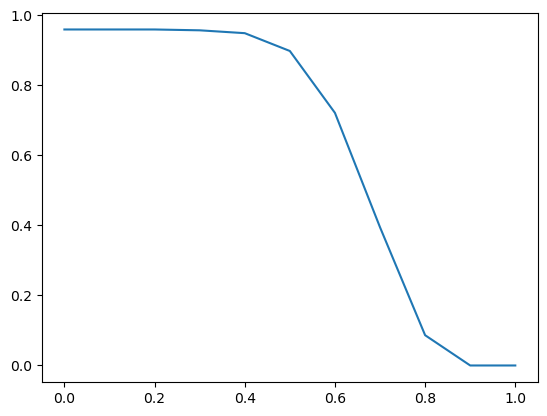

In [42]:
plt.plot(np.arange(11)/10, mean_aps)

plt.savefig(os.path.join(fig_path,
                         "metric_shells_before_pp.pdf"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=200)

np.save(os.path.join(fig_path, "metric_shells_before_pp_threshold.npy"),
        mean_aps)

print(mean_aps.mean())

In [ ]:
# check if other shell widths and positions improve the metric (which they won't)

In [11]:
# compute dilation and erosion radii fo a given shell with and position
def get_d_e_radii(width, excess_dilation):
    d_radius = np.ceil(width / 2) + excess_dilation
    e_radius = np.floor(width / 2) - excess_dilation

    d_radius = int(d_radius)
    e_radius = int(e_radius)

    assert d_radius + e_radius == width

    return d_radius, e_radius




In [12]:
get_d_e_radii(1, -2)

(-1, 2)

In [13]:
%%time
# varies position and width of the gt and pred shell jointly, will always favour wide shells
shell_widths = [1, 2, 3, 4]
excess_dilations = [-1, 0, 1]


shell_aucs = np.zeros(shape=(len(shell_widths), len(excess_dilations)))


for i, width in enumerate(shell_widths):
    for j, excess_dilation in enumerate(excess_dilations):
        d_radius, e_radius = get_d_e_radii(width, excess_dilation)
        gt_d_radius, gt_e_radius = get_d_e_radii(width, 0)
        for dataset in data_dict.keys():
            shell_segs = []
            for seg in data_dict[dataset]["pred"]:
                shell_segs.append(get_shells(seg, erosion_radius=e_radius, dilation_radius=d_radius))
            data_dict[dataset]["pred_shell"] = np.stack(shell_segs)

            gt_shell_segs = []
            for seg in data_dict[dataset]["gt"]:
                gt_shell_segs.append(get_shells(seg, erosion_radius=gt_e_radius, dilation_radius=gt_d_radius))
            data_dict[dataset]["gt_shell"] = np.stack(gt_shell_segs)

        shell_aucs[i,j] = compute_auc(data_dict, stage="pred_shell", gt_stage="gt_shell")

CPU times: user 5min 5s, sys: 678 ms, total: 5min 6s
Wall time: 5min 6s


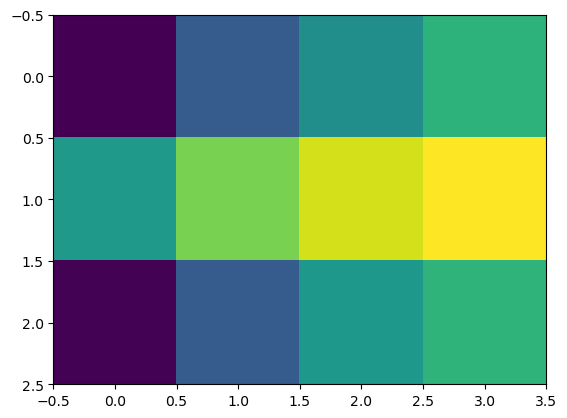

In [14]:
plt.imshow(shell_aucs.T)

--> increasing the width of both the pred and gt shell always improves the results. Not shifting the shell inwards or outwards gives the best results

In [15]:
%%time

# fix GT shell narrowly at 2 pix
shell_widths = [1, 2, 3, 4]
excess_dilations = [-1, 0, 1]


shell_aucs = np.zeros(shape=(len(shell_widths), len(excess_dilations)))


for i, width in enumerate(shell_widths):
    for j, excess_dilation in enumerate(excess_dilations):
        d_radius, e_radius = get_d_e_radii(width, excess_dilation)
        gt_d_radius, gt_e_radius = get_d_e_radii(2, 0)
        for dataset in data_dict.keys():
            shell_segs = []
            for seg in data_dict[dataset]["pred"]:
                shell_segs.append(get_shells(seg, erosion_radius=e_radius, dilation_radius=d_radius))
            data_dict[dataset]["pred_shell"] = np.stack(shell_segs)

            gt_shell_segs = []
            for seg in data_dict[dataset]["gt"]:
                gt_shell_segs.append(get_shells(seg, erosion_radius=gt_e_radius, dilation_radius=gt_d_radius))
            data_dict[dataset]["gt_shell"] = np.stack(gt_shell_segs)

        shell_aucs[i,j] = compute_auc(data_dict, stage="pred_shell", gt_stage="gt_shell")

CPU times: user 3min 54s, sys: 508 ms, total: 3min 54s
Wall time: 3min 54s


([<matplotlib.axis.XTick at 0x7f6a9c95fb80>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

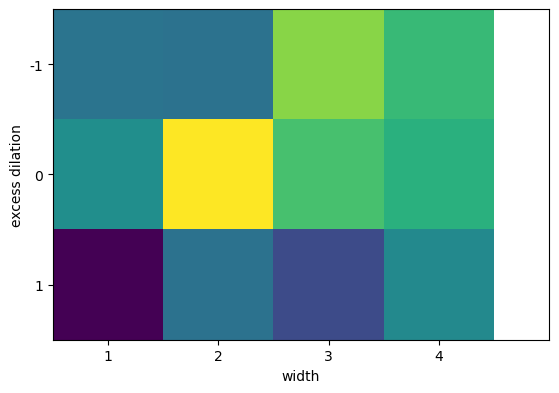

In [16]:
plt.imshow(shell_aucs.T)
plt.xlabel("width")
plt.xticks(shell_widths)

plt.ylabel("excess dilation")
plt.yticks([0, 1, 2], excess_dilations)
plt.xticks([0,1,2,3], shell_widths )

--> dilation_radius = 1 = erosion_radius seems best

In [17]:
print(shell_aucs)

[[0.30038016 0.35892961 0.09819714]
 [0.29621506 0.62611367 0.29725047]
 [0.53310468 0.47255529 0.21815868]
 [0.45445698 0.43235116 0.34661683]]
